In [2]:
!pip install pycbc scipy
from scipy.io import wavfile
from pycbc.types import TimeSeries
from pycbc.filter import matchedfilter
from pycbc.filter import matched_filter
from scipy.signal import resample

import matplotlib.pyplot as plt
import numpy as np

/home/suzanne/anaconda3/envs/phenomxpy/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/suzanne/anaconda3/envs/phenomxpy/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setupto

# Building the match function

In [3]:
# original "beep" audio file
rate, data = wavfile.read('beep.wav')

# modified "beep" audio file
rate_mod, data_mod = wavfile.read('beep_mod.wav')

/tmp/ipykernel_111886/2665366126.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read('beep.wav')
/tmp/ipykernel_111886/2665366126.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate_mod, data_mod = wavfile.read('beep_mod.wav')


In [4]:
print(f"number of channels = {data}")
print(f"sampling rate = {rate}")
length = data.shape[0] / rate
print(f"length = {length}s \n\n")

print(f"number of channels mod = {data_mod}")
print(f"sampling rate mod = {rate_mod}")
length_mod = data_mod.shape[0] / rate_mod
print(f"length mod = {length_mod}s")

number of channels = [[-227 -227]
 [-183 -183]
 [-184 -184]
 ...
 [   0    0]
 [   0    0]
 [   0    0]]
sampling rate = 44100
length = 4.348253968253968s 


number of channels mod = [[-1261 -1261]
 [-1647 -1647]
 [-1961 -1961]
 ...
 [    0     0]
 [    0     0]
 [    0     0]]
sampling rate mod = 44100
length mod = 4.348253968253968s


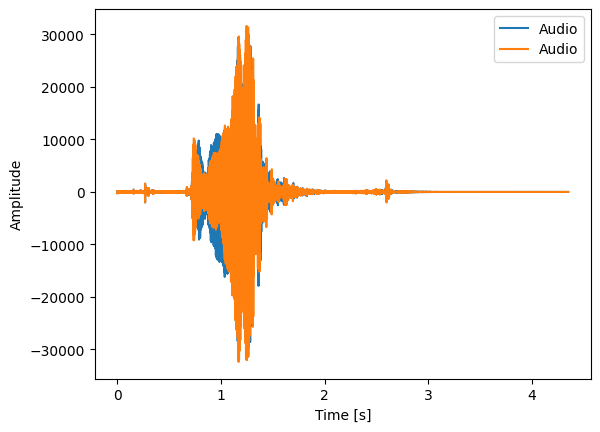

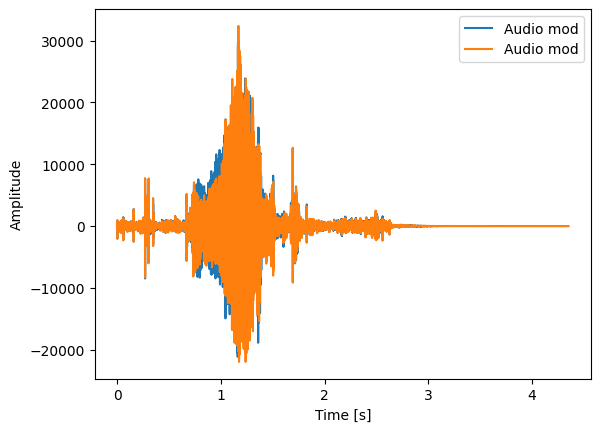

In [5]:
# stereo channels
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data, label="Audio")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

time_mod = np.linspace(0., length_mod, data_mod.shape[0])
plt.plot(time_mod, data_mod, label="Audio mod")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [6]:
# Convert to mono (pick left channel)
dataM1 = data[:, 0].astype(float)
dataM2 = data[:, 1].astype(float)

# Build TimeSeries objects with sample rate
ts1 = TimeSeries(dataM1, delta_t=1.0/rate)
ts2 = TimeSeries(dataM2, delta_t=1.0/rate)

# Compute match (normalised overlap)
m, idx = matchedfilter.match(ts1, ts1, psd=None, low_frequency_cutoff=10, high_frequency_cutoff=20000)
print("Self match:", m)

m, idx = matchedfilter.match(ts2, ts1, psd=None, low_frequency_cutoff=10, high_frequency_cutoff=20000)
print("Cross match:", m)

Self match: 1.0000000000000002
Cross match: 0.9103083555886605


In [7]:
# Convert to mono (pick left channel)
dataM1_mod = data_mod[:, 0].astype(float)
dataM2_mod = data_mod[:, 1].astype(float)

# Build TimeSeries objects with sample rate
ts1_mod = TimeSeries(dataM1, delta_t=1.0/rate)
ts2_mod = TimeSeries(dataM2, delta_t=1.0/rate)

# Compute match (normalised overlap)
m, idx = matchedfilter.match(ts1, ts1, psd=None, low_frequency_cutoff=10, high_frequency_cutoff=20000)
print("Self match:", m)

m, idx = matchedfilter.match(ts2, ts1, psd=None, low_frequency_cutoff=10, high_frequency_cutoff=20000)
print("Cross match:", m)

Self match: 1.0000000000000002
Cross match: 0.9103083555886605


In [8]:
# Compute match 
m, idx = matchedfilter.match(ts1_mod, ts1, psd=None, low_frequency_cutoff=10, high_frequency_cutoff=20000)
print("Self match:", m)

m, idx = matchedfilter.match(ts2_mod, ts2, psd=None, low_frequency_cutoff=10, high_frequency_cutoff=20000)
print("Cross match:", m)

Self match: 1.0000000000000002
Cross match: 1.0000000000000002


In [9]:
def compute_snr(data1, data2, low_frequency_cutoff=20.0):
    # compute snr
    snr_ts = matched_filter(data1, data2, psd=None, low_frequency_cutoff=low_frequency_cutoff)

    snr_abs = abs(snr_ts)            
    peak_idx = np.argmax(snr_abs.numpy())  
    peak_snr = snr_abs[peak_idx]

    return peak_snr


In [10]:
# compute snr
peak_snr_self = compute_snr(ts1, ts1)
print('Self snr: ', peak_snr_self)

peak_snr_cross = compute_snr(ts1, ts2)
print('Cross snr: ', peak_snr_cross)


Self snr:  11809.520540007055
Cross snr:  11210.541242413192


# Getting the LIGO GW150914 audio file

In [11]:
# Observed waveform, whitened and band-passed 20 - 300 Hz, and shifted up by 400 Hz, for H1 and L1
rate_H1, data_H1 = wavfile.read('GW150914_H1_shifted.wav')

# modified "beep" audio file
rate_L1, data_L1 = wavfile.read('GW150914_L1_shifted.wav')

In [12]:
print(f"number of channels H1 = {data_H1}")
print(f"sampling rate H1 = {rate_H1}")
length_H1 = data_H1.shape[0] / rate_H1
print(f"length H1 = {length_H1}s \n\n")

print(f"number of channels L1 = {data_L1}")
print(f"sampling rate L1 = {rate_L1}")
length_L1 = data_L1.shape[0] / rate_L1
print(f"length L1 = {length_L1}s")

number of channels H1 = [  274 -1177 -1788 ...  1367 -2215 -4746]
sampling rate H1 = 4096
length H1 = 4.0s 


number of channels L1 = [  830 -2611 -5180 ... -5268  2898  9790]
sampling rate L1 = 4096
length L1 = 4.0s


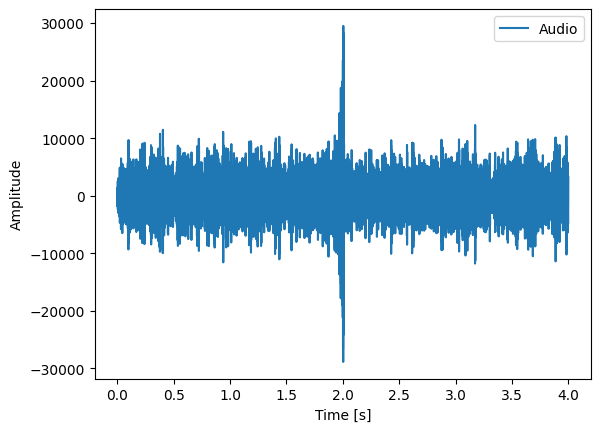

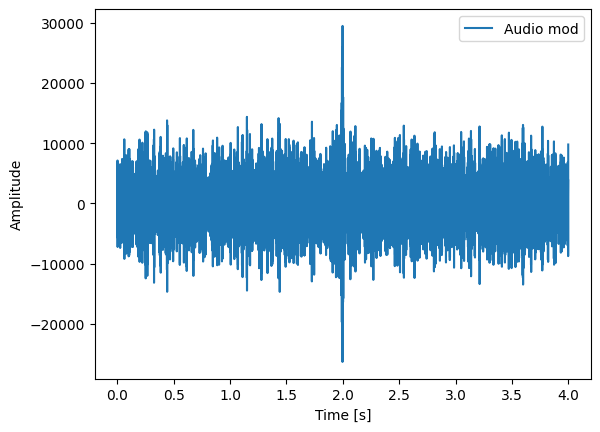

In [13]:
# stereo channels
time_H1 = np.linspace(0., length_H1, data_H1.shape[0])
plt.plot(time_H1, data_H1, label="Audio")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

time_L1 = np.linspace(0., length_L1, data_L1.shape[0])
plt.plot(time_L1, data_L1, label="Audio mod")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [14]:
# Build TimeSeries objects with sample rate
tsH = TimeSeries(data_H1, delta_t=1.0/rate_H1)
tsL = TimeSeries(data_L1, delta_t=1.0/rate_L1)

# Compute match (normalised overlap)
m, idx = matchedfilter.match(tsH, tsL, psd=None, low_frequency_cutoff=20, high_frequency_cutoff=300)
print("H1 & L1 Match:", m)


H1 & L1 Match: 0.9968695216210317


# Match of original and mimicers check

In [15]:
ts_mimic = ts1
print(ts_mimic.delta_t, ts_mimic.sample_rate, len(ts_mimic))
print(ts1, ts2, tsL)


2.2675736961451248e-05 44100.0 191758
[-227. -183. -184. ...    0.    0.    0.] [-227. -183. -184. ...    0.    0.    0.] [  830. -2611. -5180. ... -5268.  2898.  9790.]


In [16]:
def align_sampling(ts_a, ts_b):
    """
    Resample ts_b so that it has the same delta_t and length as ts_a.
    Returns (ts_a, ts_b_aligned).
    """
    if ts_a.delta_t == ts_b.delta_t and len(ts_a) == len(ts_b):
        return ts_a, ts_b

    N = len(ts_a)
    data_resampled = resample(ts_b.numpy(), N)  # Fourier-based resample
    ts_b_new = TimeSeries(data_resampled, delta_t=ts_a.delta_t)
    return ts_a, ts_b_new

def pad_or_truncate(ts_mimic, ts_match):
    """Make ts the same length as target_len by padding or truncating."""
    target_length = len(ts_match)

    ts_match, ts_mimic = align_sampling(ts_match, ts_mimic)

    data_mimic = ts_mimic.numpy()
    if len(data_mimic) < target_length:
        pad_width = target_length - len(data_mimic)
        data_mimic = np.pad(data, (0, pad_width), mode="constant")
    else:
        data_mimic = data_mimic[:target_length]

                # ts_match2 = TimeSeries(ts_match.numpy().astype(np.float64), delta_t=ts_mimic.delta_t)

    # def plot_spectrum(ts, label, color):
    #             N = len(ts)
    #             freqs = np.fft.rfftfreq(N, d=ts.delta_t)
    #             spec = np.abs(np.fft.rfft(ts.numpy() * np.hanning(N)))
    #             plt.plot(freqs, spec/spec.max(), label=label, color=color, alpha=0.7)
                
    # f_low = 10
    # f_high = 20000
    # plt.figure(figsize=(10,6))
    # plot_spectrum(ts_match, "Real chirp", "black")
    # # plot_spectrum(ts_match2, "Mimic ch1", "blue")


    # plt.axvline(f_low, color="green", linestyle="--", label=f"low_f={f_low} Hz")
    # plt.axvline(f_high, color="orange", linestyle="--", label=f"high_f={f_high} Hz")

    # plt.xlim(0, min(f_high*1.2, rate/2))
    # plt.yscale("log")
    # plt.xlabel("Frequency [Hz]")
    # plt.ylabel("Normalized |FFT|")
    # plt.title("Spectra of real chirp vs mimic(s)")
    # plt.legend()
    # plt.grid(True, which="both", ls="--", lw=0.5)
    # plt.show()

    return ts_match, TimeSeries(data_mimic, delta_t=ts_mimic.delta_t)


In [17]:
ts_match, ts_mimic = pad_or_truncate(ts_mimic, tsL)
print(ts_match)

[  830. -2611. -5180. ... -5268.  2898.  9790.]


In [18]:
# compute snr
peak_snr = compute_snr(tsH, ts_mimic)
print('peak snr of H1 & mimic: ', peak_snr)

peak_snr = compute_snr(tsL, ts_mimic)
print('peak snr of L1 & mimic: ', peak_snr)

peak snr of H1 & mimic:  146.33560595401255
peak snr of L1 & mimic:  138.18460855912872


In [19]:
m, idx = matchedfilter.match(tsH, ts_mimic, psd=None, low_frequency_cutoff=20, high_frequency_cutoff=300)
print("H1 & mimic match:", m)
print(ts1, ts2, tsL)
m, idx = matchedfilter.match(tsL, ts_mimic, psd=None, low_frequency_cutoff=20, high_frequency_cutoff=300)
print("L1 & mimic match:", m)

H1 & mimic match: 0.2574779238563277
[-227. -183. -184. ...    0.    0.    0.] [-227. -183. -184. ...    0.    0.    0.] [  830. -2611. -5180. ... -5268.  2898.  9790.]
L1 & mimic match: 0.23929365126298016


# Final comparison function

In [77]:

def compare_mimic(wav_file_mimic, wav_file_real, low_frequency_cutoff=10, high_frequency_cutoff=600):
    rate_mimic, data_mimic = wavfile.read(wav_file_mimic)
    rate_real, data_real = wavfile.read(wav_file_real)

    # Force both to float64 
    dataM1 = data_mimic.astype(np.float32)
    dataR1 = data_real.astype(np.float32)

    # convert to TimeSeries 
    ts1 = TimeSeries(dataM1, delta_t=1.0/rate_mimic, dtype=np.float64)
    ts_real = TimeSeries(dataR1, delta_t=1.0/rate_real, dtype=np.float64)

    def plot_spectrum(ts, label, color):
                N = len(ts)
                freqs = np.fft.rfftfreq(N, d=ts.delta_t)
                spec = np.abs(np.fft.rfft(ts.numpy() * np.hanning(N)))
                plt.plot(freqs, spec/spec.max(), label=label, color=color, alpha=0.7)
                

    # Adjust length to match real chirp signal
    ts_real, ts1 = pad_or_truncate(ts1, ts_real)
    
    f_low = low_frequency_cutoff
    f_high = high_frequency_cutoff

#     plt.figure(figsize=(10,6))
#     plot_spectrum(ts_real, "Real chirp", "black")
#     plot_spectrum(ts1, "Mimic ch1", "blue")
#     # plot_spectrum(ts2, "Mimic ch2", "red")

#     plt.axvline(f_low, color="green", linestyle="--", label=f"low_f={f_low} Hz")
#     plt.axvline(f_high, color="orange", linestyle="--", label=f"high_f={f_high} Hz")

#     plt.xlim(0, min(f_high*1.2, rate_mimic/2))
#     plt.yscale("log")
#     plt.xlabel("Frequency [Hz]")
#     plt.ylabel("Normalized |FFT|")
#     plt.title("Spectra of real chirp vs mimic(s)")
#     plt.legend()
#     plt.grid(True, which="both", ls="--", lw=0.5)
#     plt.show()


    # Compute match (normalised overlap)
    m1, idx = matchedfilter.match(ts1, ts_real, psd=None, low_frequency_cutoff=low_frequency_cutoff, high_frequency_cutoff=high_frequency_cutoff)
    # m2, idx = matchedfilter.match(ts_real, ts2, psd=None, low_frequency_cutoff=low_frequency_cutoff, high_frequency_cutoff=high_frequency_cutoff)

    # Normalization to 50% being the max, just for better experience (disclaimer: not very scientific)
    mean_match = m1/0.5

    if mean_match > 1.0:
            mean_match = 1.0
    # mean_match = (m1 + m2)/2
    # print(f'Match channel1: {m1*100}% | Match channel2: {m2*100}%')
    print('Mean match of mimic and real chirp: ', np.round(mean_match, 3)*100, '%')

    return np.round(mean_match, 3)*100


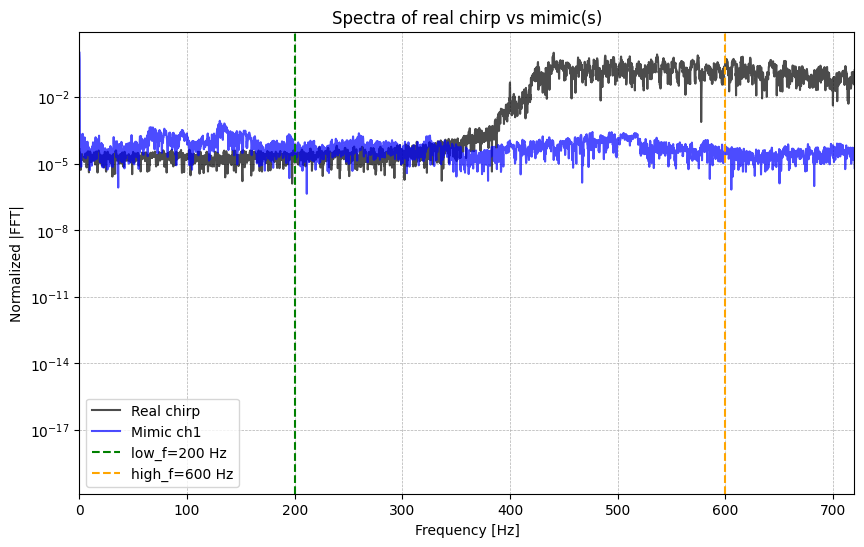

Mean match of mimic and real chirp:  15.5 %


In [76]:
match = compare_mimic('check2.wav', 'GW150914_L1_shiftedslower.wav', low_frequency_cutoff=200, high_frequency_cutoff=600)
# match = compare_mimic('check3.wav', 'GW150914_L1_shiftedslower.wav')
# match = compare_mimic('beep_mod.wav', 'GW150914_H1_shifted.wav')
# match = compare_mimic('beep_mod.wav', 'GW150914_L1_shifted.wav')


In [92]:
import os


folder = "/home/suzanne/anaconda3/Python_scripts/Chirp_whoop_recognition/whoop/wavfiles/"
files = os.listdir(folder)

matches = []

for file in files:
    match = compare_mimic(folder + file, 'GW150914_L1_shiftedslower.wav',
                          low_frequency_cutoff=200, high_frequency_cutoff=600)
    matches.append((round(float(match), 2), file))
   

# Convert to a structured NumPy array if you like
matches = np.array(matches, dtype=object)  # or leave as list of tuples
matches_sorted = sorted(matches, key=lambda x: x[0], reverse=True)
filenames_sorted = [filename for score, filename in matches_sorted]
print(matches_sorted)
for i, filename in enumerate(filenames_sorted, start=1):
    print(f"{i}. {filename}")
print(filenames_sorted)


Mean match of mimic and real chirp:  12.9 %
Mean match of mimic and real chirp:  7.8 %
Mean match of mimic and real chirp:  19.0 %
Mean match of mimic and real chirp:  11.3 %
Mean match of mimic and real chirp:  17.0 %
Mean match of mimic and real chirp:  11.3 %
Mean match of mimic and real chirp:  14.299999999999999 %
Mean match of mimic and real chirp:  15.9 %
Mean match of mimic and real chirp:  24.2 %
Mean match of mimic and real chirp:  5.6000000000000005 %
Mean match of mimic and real chirp:  10.4 %
Mean match of mimic and real chirp:  9.3 %
Mean match of mimic and real chirp:  25.7 %
Mean match of mimic and real chirp:  8.9 %
Mean match of mimic and real chirp:  15.8 %
Mean match of mimic and real chirp:  6.7 %
Mean match of mimic and real chirp:  20.7 %
Mean match of mimic and real chirp:  22.3 %
Mean match of mimic and real chirp:  27.1 %
Mean match of mimic and real chirp:  2.9000000000000004 %
[array([27.1, 'Felice_20250919_181923.wav'], dtype=object), array([25.7, 'pooya_20